# Wrapper Prototype

In [1]:
import pandas as pd
import yfinance as yf

from mplchart.chart import Chart
from mplchart.primitives import Candlesticks, Volume
from mplchart.indicators import SMA, RSI, MACD

In [2]:
ticker = "AAPL"
prices = yf.Ticker(ticker).history(period="5y")
prices = prices.rename(columns=str.lower).rename_axis(index=str.lower)
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-09-30 00:00:00-04:00 to 2024-09-27 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          1258 non-null   float64
 1   high          1258 non-null   float64
 2   low           1258 non-null   float64
 3   close         1258 non-null   float64
 4   volume        1258 non-null   int64  
 5   dividends     1258 non-null   float64
 6   stock splits  1258 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.6 KB


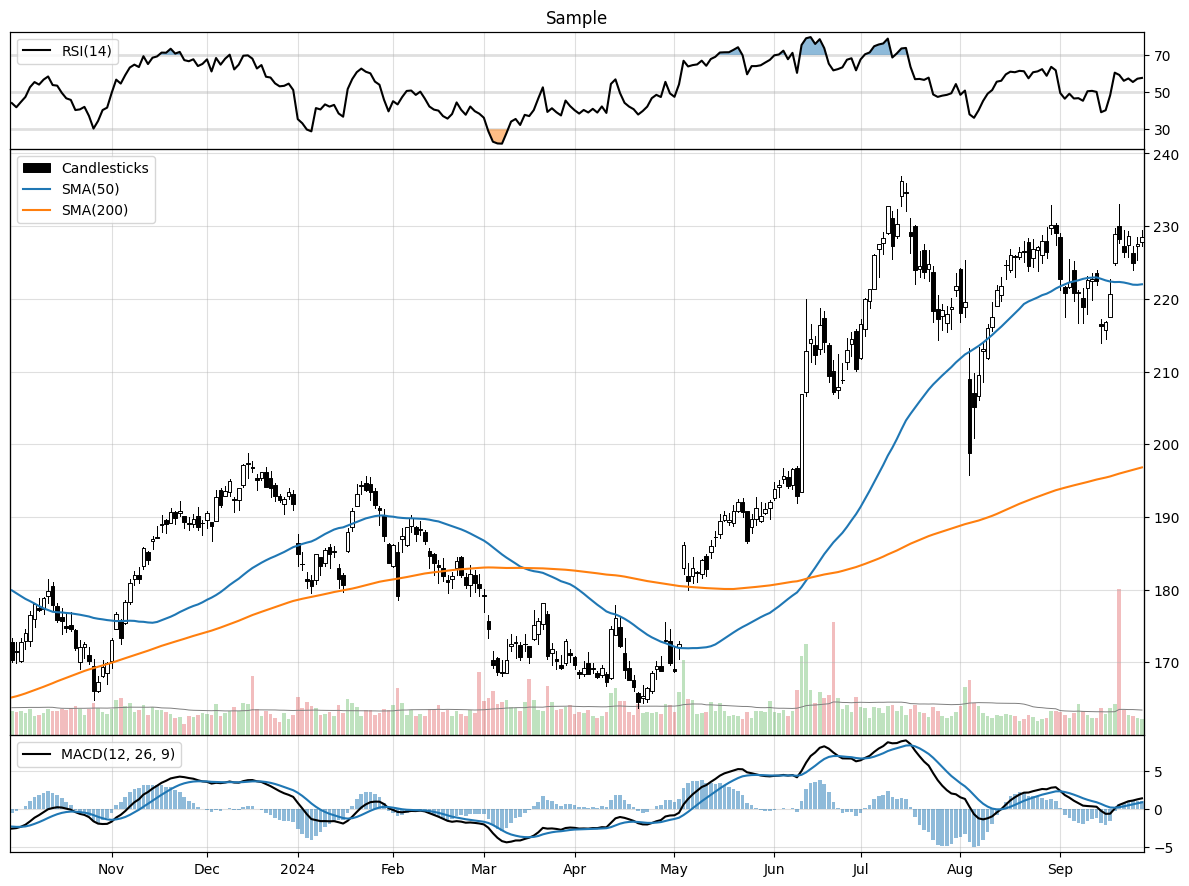

In [3]:
max_bars = 250
indicators = [Candlesticks(), Volume(), SMA(50), SMA(200), RSI(), MACD()]

chart = Chart(title="Sample", max_bars=max_bars)
chart.plot(prices, indicators)

TypeError: Can't instantiate abstract class WrapperPlot with abstract method plot_result

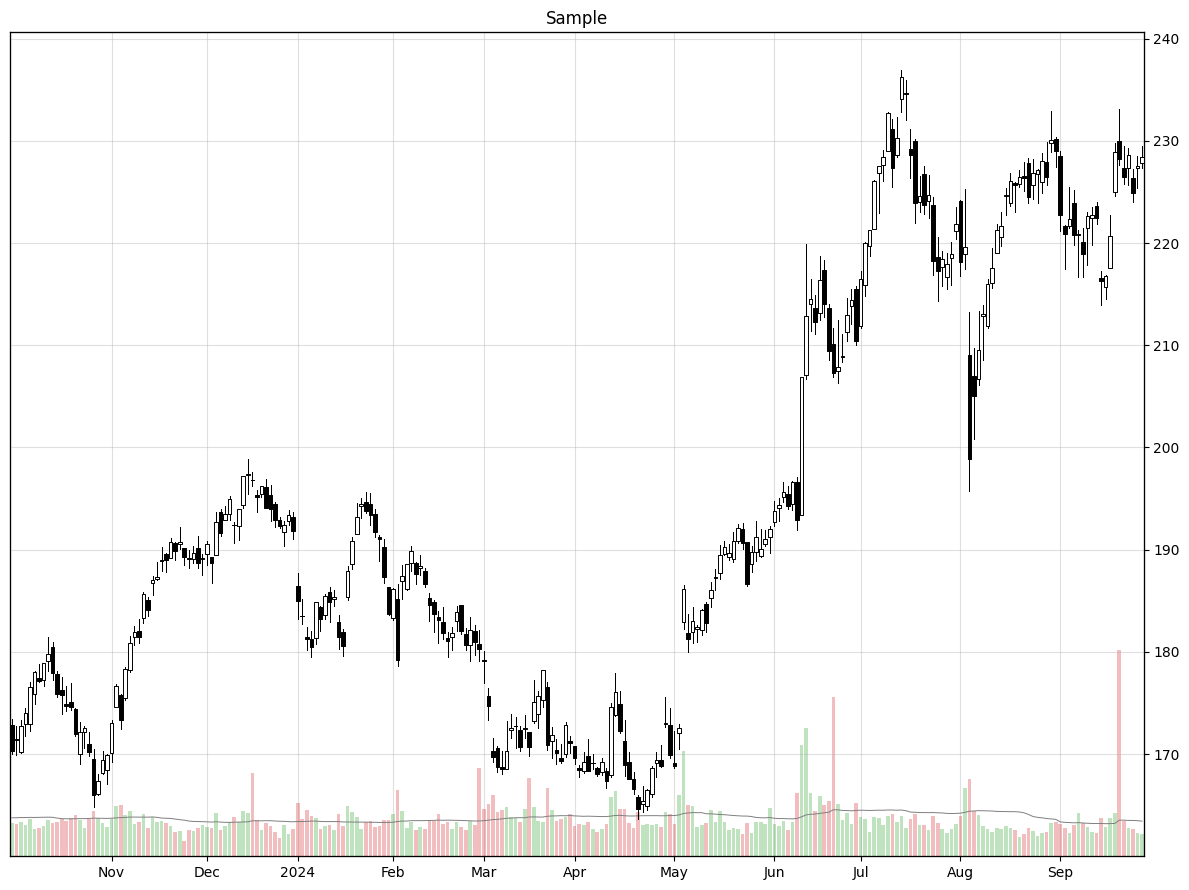

In [4]:
import warnings

from mplchart.model import Wrapper
from functools import cached_property

SOLID_LINE = "line"
HISTOGRAM = "bars"
DASHED_LINE = "dashed"
UPPER_LIMIT = "upper-limit"
LOWER_LIMIT = "lower-limit"


class ForceWrap:
    def __init__(self, output_flags=None):
        kwds = {
            k:v for k,v in locals().items()
            if k != "self" and v is not None
        }
        self.kwds = kwds

    def __ror__(self, other):
        other.__dict__.update(self.kwds)

        if not callable(other):
            return NotImplemented
        return WrapperProto(other)


class WrapperProto(Wrapper):
    def __init__(self, indicator):
        self.indicator = indicator

    def __call__(self, data):
        return self.indicator(data)

    @cached_property
    def name(self):
        if hasattr(self.indicator, "name"):
            return self.indicator.name

        if hasattr(self.indicator, "__name__"):
            return self.indicator.__name__

        if hasattr(self.indicator, "__class__"):
            return self.indicator.__class__.__name__

        raise ValueError("Indicator has no name")

    @cached_property
    def same_scale(self):
        return getattr(self.indicator, "same_scale", None)

    @cached_property
    def output_names(self):
        return getattr(self.indicator, "output_names", None)
    
    @cached_property
    def output_flags(self):
        return getattr(self.indicator, "output_flags", None)


    def iter_items(self, prices):
        output_names = self.output_names
        output_flags = self.output_flags

        if isinstance(output_flags, dict):
            return output_flags.items()

        output_names = self.output_names

        if not output_names:
            if hasattr(prices, 'columns'):
                output_names = tuple(prices.columns)
            else:
                output_names = (self.name, )

        if not output_names:
            if hasattr(prices, 'columns'):
                output_names = tuple(prices.columns)
            else:
                output_names = (self.name, )

        if not output_flags:
            output_flags = tuple("line" for n  in output_names)



        if isinstance(output_flags, tuple):
            return zip(output_names, output_flags)
        
        
        return getattr(self.indicator, "output_flags", None)


    def plot_result(self, data, chart, ax=None):
        if ax is None:
            ax = self.get_axes(chart)

        upper_limit, lower_limit = None, None

        for name, flags in self.indicator.output_flags.items():
            label = self.get_label() if name in ("real", "interer") else name

            for flag in flags:
                if flag == HISTOGRAM:
                    xv, yv = self.series_data(data, name)
                    ax.bar(xv, yv, alpha=0.5, width=0.8, label=label)
                    continue

                linestyle = None

                if flag == SOLID_LINE:
                    linestyle = "-"
                elif flag == DASHED_LINE:
                    linestyle = "--"
                elif flag in UPPER_LIMIT:
                    upper_limit = name
                    linestyle = "-."
                elif flag == LOWER_LIMIT:
                    lower_limit = name
                    linestyle = "-."
                else:
                    warnings.warn(f"Unknown flag {flag!r}")

                xv, yv = self.series_data(data, name)
                ax.plot(xv, yv, linestyle=linestyle, label=label)

        if upper_limit and lower_limit:
            xs, us = self.series_data(data, upper_limit)
            xs, ls = self.series_data(data, lower_limit)
            ax.fill_between(xs, ls, us, interpolate=True, alpha=0.2)



In [ ]:


class WrapperPlot(Wrapper):

    def __init__(self, wrapper, *, data, chart, ax=None):
        self.wrapper = wrapper
        self.data = data
        self.chart = chart
        if ax is not None:
            self.ax = ax

    @cached_property
    def ax(self):
        target = "samex" if self.wrapper.same_scale else "below"
        return chart.get_axes(target)

    @cached_property
    def stylemap(self):
        return chart.get_stylemap(self.ax, self.wrapper.stylemap)


    @cached_property
    def output_names(self):
        if hasattr(self.wrapper, "output_names"):
            return self.wrapper.output_names
        
        if hasattr(self.data, "columns"):
            return tuple(self.data.columns)
        
        name = self.wrapper.indicator_name().lower()

        return tuple([name])
    
    @cached_property
    def output_flags(self):
        if hasattr(self.wrapper, "output_flags"):
            return self.wrapper.output_flags
        
        names = self.output_names
        return tuple("line" for n in names)

    @cached_property
    def output_items(self):
        names = self.output_names
        flags = self.output_flags
        return zip(names, flags)

    def series_data(self, name):
        if self.data.__class__.__name__ == "Series":
            series = self.data
        else:
            series = self.data[name]
        return series

    def series_xy(self, name):
        series = self.series_data(name)
        return series.index.values, series.values

    def get_style(self, name=None, **kwds):
        style_map = getattr(self.indicator, "style_map", dict())

        for key, value in kwds.items():
            skey = name + ":" + key if name else key
            value = style_map.get(skey, value)

    def plot_line(self, name=None, label=None):
        xv, yv  = self.series_xy(name)
        kwds = self.get_style(name, linestyle=None, linewidth=None, color=None)
        self.ax.plot(xv, yv, label=label, **kwds)

    def plot_bars(self, name=None, label=None):
        xv, yv  = self.series_xy(name)
        kwds = self.get_style(name, alpha=0.5, width=0.8, color=None)
        self.ax.bar(xv, yv, label=label, **kwds)

    def plot_band(self, lower, upper, ax, name=None, label=None):
        xv, yv = self.series_xy(lower)
        xv, zv = self.series_xy(upper)
        kwds = self.get_style(name, alpha=0.2, color=None)
        self.ax.fill_between(xv, yv, zv, interpolate=True, label=label, **kwds)


    def render(self):
        upper_limit, lower_limit = None, None

        for name, flag in self.output_items:
            print("item", name, flag)
            
            label = repr(self) if name in ("real", "interer") else name

            if flag == HISTOGRAM:
                xv, yv = self.series_data(name)
                self.ax.bar(xv, yv, alpha=0.5, width=0.8, label=label)
                continue

            linestyle = None

            if flag == SOLID_LINE:
                linestyle = "-"
            elif flag == DASHED_LINE:
                linestyle = "--"
            elif flag == UPPER_LIMIT:
                upper_limit = name
                linestyle = "-."
            elif flag == LOWER_LIMIT:
                lower_limit = name
                linestyle = "-."
            else:
                warnings.warn(f"Unknown flag {flag!r}", stacklevel=2)

            xv, yv = self.series_data(name)
            self.ax.plot(xv, yv, linestyle=linestyle, label=label)

        if upper_limit and lower_limit:
            xs, us = self.series_xy(upper_limit)
            xs, ls = self.series_xy(lower_limit)
            self.ax.fill_between(xs, ls, us, interpolate=True, alpha=0.2)



max_bars = 250
indicators = [
    Candlesticks(),
    Volume(),
    SMA(50) | ForceWrap(output_flags=("line",)),
    SMA(200) | ForceWrap(output_flags=("dashed",)),
    RSI() | ForceWrap(output_flags=("bars", )),
    MACD()
]

chart = Chart(title="Sample", max_bars=max_bars)
chart.plot(prices, indicators)
